In [1]:
# !pip install matplotlib pandas

In [1]:
import os
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

In [3]:
CWD = Path(os.getcwd())

log_file = 'workload.log'
flush_stats_file = 'flush_stats.csv'
compaction_stats_file = 'compaction_stats.csv'
inserts_stats_file = 'insert_stats.csv'
pq_stats_file = 'pq_stats.csv'

FIGSIZE = (32, 24)

# plt.style.use('seaborn-v0_8-darkgrid')

In [4]:
def split_by_eq_pull_time(string):
    tmp = string.split(' = ')[1]
    return float(tmp.split(' ')[0])

def get_times(lines):
    """ Get workload exection Time """

    exection_times = {
        'workloadTime': 0,
        'insertsTime': 0,
        'queriesTime': 0,
        'updatesTime': 0,
        'deletesTime': 0,
        'rangeQueriesTime': 0
    }

    for line in lines:
        if line.startswith('Total time taken by workload'):
            exection_times['workloadTime'] = split_by_eq_pull_time(line)
        if line.startswith('Total time taken by inserts'):
            exection_times['insertsTime'] = split_by_eq_pull_time(line)
        if line.startswith('Total time taken by queries'):
            exection_times['queriesTime'] = split_by_eq_pull_time(line)
        if line.startswith('Total time taken by updates'):
            exection_times['updatesTime'] = split_by_eq_pull_time(line)
        if line.startswith('Total time taken by deletes'):
            exection_times['deletesTime'] = split_by_eq_pull_time(line)
        if line.startswith('Total time taken by range queries'):
            exection_times['rangeQueriesTime'] = split_by_eq_pull_time(line)

    return exection_times

def get_flush_stats(df):
    """ Get flush stats in term of total number of flushes, avg data size, avg number of entries """

    flush_stats = {
        'timePoints': df['TimePoint'],
        'totalFlushes': df.shape[0] - 1,
        'avgDataSize': df['DataSize'][:-1].mean(),
        'avgNumEntries': df['NumEntries'][:-1].mean(),
        'lastFlushEntries': df['NumEntries'].iloc[-1],
    }

    return flush_stats


In [5]:
all_directories = os.listdir()
all_stats = list()

for dirpath in all_directories:
    if not os.path.isdir(dirpath) or 'old' in dirpath:
        continue

    prefix_len = 0
    bucket_count = 1

    if 'bucket_count' not in dirpath:
        _, inserts, _, updates, _, range_queries, _, selectivity, _, point_queries, _, memtable, _, entry_size, _, epp, _, buffer_size_in_pages, _, size_ratio = dirpath.split(' ')
    else:
        _, inserts, _, updates, _, range_queries, _, selectivity, _, point_queries, _, memtable, _, entry_size, _, epp, _, buffer_size_in_pages, _, size_ratio, _, prefix_len, _, bucket_count = dirpath.split(' ')

    # print(f"Processing {dirpath}")

    exp = {
        'inserts': int(inserts),
        'updates': int(updates),
        'rangeQueries': int(range_queries),
        'selectivity': float(selectivity),
        'pointQueries': int(point_queries),
        'memtable': memtable.capitalize(),
        'entrySize': int(entry_size),
        'entriesPerPage': int(epp),
        'bufferSizeInPages': int(buffer_size_in_pages),
        'pageSize': int(entry_size) * int(epp),
        'bufferSize': int(entry_size) * int(epp) * int(buffer_size_in_pages),
        'sizeRatio': int(size_ratio),
        'prefixLen': int(prefix_len),
        'bucketCount': int(bucket_count)
    }

    logfilepath = Path(dirpath) / log_file
    time_stats = dict()

    with open(logfilepath, 'r') as f:
        lines = f.readlines()
        time_stats = get_times(lines)
    
    exp.update(time_stats)

    flushfilepath = Path(dirpath) / flush_stats_file
    compactionfilepath = Path(dirpath) / compaction_stats_file
    insertsfilepath = Path(dirpath) / inserts_stats_file
    pqfilepath = Path(dirpath) / pq_stats_file

    if flushfilepath.exists():
        flush_stats = pd.read_csv(flushfilepath)
        flush_stats = get_flush_stats(flush_stats)
        exp.update(flush_stats)
    else:
        exp.update({
            'timePoints': 0,
            'totalFlushes': 0,
            'avgDataSize': 0,
            'avgNumEntries': 0
        })

    if insertsfilepath.exists():
        exp.update({
            'insertsDf': pd.read_csv(insertsfilepath)
        })

    all_stats.append(exp)
        

In [6]:
df = pd.DataFrame(all_stats)

In [7]:
dff = df[['memtable', 'prefixLen', 'bucketCount', 'insertsTime', 'rangeQueriesTime', 'insertsDf']]

In [8]:
dff[['memtable', 'prefixLen', 'bucketCount', 'rangeQueriesTime', 'insertsDf']]

skip_list = dff[dff['memtable'] == 'Skiplist']
vector = dff[dff['memtable'] == 'Vector']

In [9]:
vec_insert_df = vector.iloc[0]['insertsDf']

In [10]:
skip_insert_df = skip_list.iloc[0]['insertsDf']

In [ ]:

fig, ax = plt.subplots(figsize=FIGSIZE)
# ax.plot(skip_insert_df.index[0:6400], skip_insert_df['TimeTaken'][0:6400], color='royalblue', label='Skip List')
# ax.plot(vec_insert_df.index[0:6400], vec_insert_df['TimeTaken'][0:6400], alpha=0.4, color='maroon', label='Vector')
ax.plot(skip_insert_df.index[0:6400], skip_insert_df['TimeTaken'][0:6400], color='royalblue', label='Skip List')
ax.plot(vec_insert_df.index[0:6400], vec_insert_df['TimeTaken'][0:6400], alpha=0.4, color='maroon', label='Vector')
ax.set_xlabel('Time Point')
ax.set_ylabel('Time Taken (Seconds)')
ax.legend()
ax.set_ylim(0, 0.0001)

print("Skip List\n", skip_insert_df.sum())
print("\n\n")
print("Vector\n", vec_insert_df.sum())

In [12]:
vec_log_file = "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-PQ-TEST-64/I 140000 U 0 S 0 Y 0 Q 0 m vector E 64 B 64 P 4096 T 4/workload.log"
skip_log_file = "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-PQ-TEST-64/I 140000 U 0 S 0 Y 0 Q 0 m skiplist E 64 B 64 P 4096 T 4/workload.log"

vec_df = pd.read_csv(vec_log_file, names=['TimeTaken'])
skip_df = pd.read_csv(skip_log_file, names=['TimeTaken'])

vec_df = vec_df.apply(lambda x : x / (10**6))
skip_df = skip_df.apply(lambda x : x / (10**6))

(-5e-06, 0.0003)

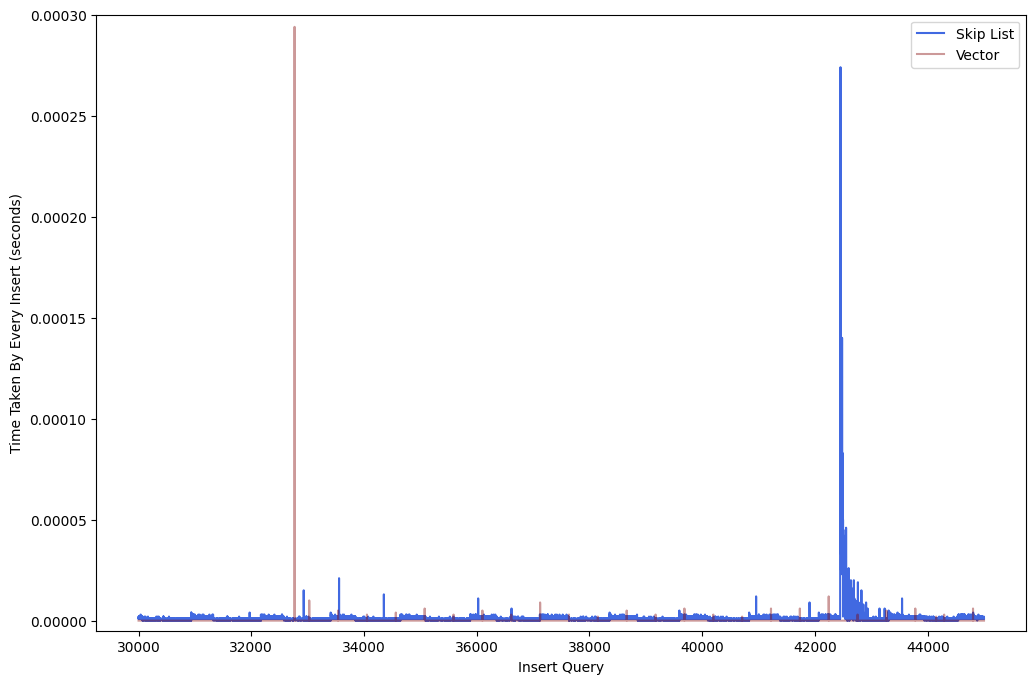

In [13]:
FIGSIZE = (12, 8)
fig, ax = plt.subplots(figsize=FIGSIZE)
# ax.plot(skip_df.index, skip_df['TimeTaken'], color='royalblue', label='Skip List')
# ax.plot(vec_df.index, vec_df['TimeTaken'], alpha=0.4, color='maroon', label='Vector')
ax.plot(skip_df.index[30000:45000], skip_df['TimeTaken'][30000:45000], color='royalblue', label='Skip List')
ax.plot(vec_df.index[30000:45000], vec_df['TimeTaken'][30000:45000], alpha=0.4, color='maroon', label='Vector')
ax.set_xlabel('Insert Query')
ax.set_ylabel('Time Taken By Every Insert (seconds)')
ax.legend()
# ax.set_ylim(bottom= -0.0001, top=0.0013)
ax.set_ylim(-0.000005, 0.00030)
# ax.set_yscale('log')

In [2]:
import io

vec_log_file = "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-PQ-64/I 140000 U 0 S 0 Y 0 Q 1000 m vector E 64 B 64 P 4096 T 4/workload.log"
skip_log_file = "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-PQ-64/I 140000 U 0 S 0 Y 0 Q 1000 m skiplist E 64 B 64 P 4096 T 4/workload.log"
hash_skip_list_file_0_100000 = "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-PQ-64/I 140000 U 0 S 0 Y 0 Q 1000 m hashskiplist E 64 B 64 P 4096 T 4 l 0 bucket_count 100000/workload.log"
hash_link_list_file_0_100000 = "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-PQ-64/I 140000 U 0 S 0 Y 0 Q 1000 m hashlinklist E 64 B 64 P 4096 T 4 l 0 bucket_count 100000/workload.log"
hash_skip_list_file_10_1 = "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-PQ-64/I 140000 U 0 S 0 Y 0 Q 1000 m hashskiplist E 64 B 64 P 4096 T 4 l 10 bucket_count 1/workload.log"
hash_link_list_file_10_1 = "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-PQ-64/I 140000 U 0 S 0 Y 0 Q 1000 m hashlinklist E 64 B 64 P 4096 T 4 l 10 bucket_count 1/workload.log"
hash_skip_list_file_6_100000 = "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-PQ-64/I 140000 U 0 S 0 Y 0 Q 1000 m hashskiplist E 64 B 64 P 4096 T 4 l 6 bucket_count 100000/workload.log"
hash_link_list_file_6_100000 = "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-PQ-64/I 140000 U 0 S 0 Y 0 Q 1000 m hashlinklist E 64 B 64 P 4096 T 4 l 6 bucket_count 100000/workload.log"
hash_skip_list_file_2_10000 = "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-PQ-64/I 140000 U 0 S 0 Y 0 Q 1000 m hashskiplist E 64 B 64 P 4096 T 4 l 2 bucket_count 10000/workload.log"
hash_link_list_file_2_10000 = "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-PQ-64/I 140000 U 0 S 0 Y 0 Q 1000 m hashlinklist E 64 B 64 P 4096 T 4 l 2 bucket_count 10000/workload.log"


hash_skip_lines_0_100000 = list()
hash_link_lines_0_100000 = list()
hash_skip_lines_10_1 = list()
hash_link_lines_10_1 = list()
hash_skip_lines_6_100000 = list()
hash_link_lines_6_100000 = list()
hash_skip_lines_2_10000 = list()
hash_link_lines_2_10000 = list()

vec_lines = list()
for line in open(vec_log_file).readlines():
    if "PointQueryTime:" in line:
        vec_lines.append(line)


vec_sort_lines = list()
for line in open(vec_log_file).readlines():
    if "SortingTime: " in line:
        vec_sort_lines.append(line)


skip_lines = list()
for line in open(skip_log_file).readlines():
    if "PointQueryTime:" in line:
        skip_lines.append(line)

for line in open(hash_skip_list_file_0_100000).readlines():
    if "PointQueryTime:" in line:
        hash_skip_lines_0_100000.append(line)

# hash_skip_lines_hash = list()
# for line in open(hash_skip_list_file).readlines():
#     if "PointQueryTime:" not in line:
#         hash_skip_lines_hash.append(line)

for line in open(hash_link_list_file_0_100000).readlines():
    if "PointQueryTime:" in line:
        hash_link_lines_0_100000.append(line)



for line in open(hash_skip_list_file_10_1).readlines():
    if "PointQueryTime:" in line:
        hash_skip_lines_10_1.append(line)


for line in open(hash_link_list_file_10_1).readlines():
    if "PointQueryTime:" in line:
        hash_link_lines_10_1.append(line)


for line in open(hash_skip_list_file_6_100000).readlines():
    if "PointQueryTime:" in line:
        hash_skip_lines_6_100000.append(line)


for line in open(hash_link_list_file_6_100000).readlines():
    if "PointQueryTime:" in line:
        hash_link_lines_6_100000.append(line)


for line in open(hash_skip_list_file_2_10000).readlines():
    if "PointQueryTime:" in line:
        hash_skip_lines_2_10000.append(line)


for line in open(hash_link_list_file_2_10000).readlines():
    if "PointQueryTime:" in line:
        hash_link_lines_2_10000.append(line)




skip_df = pd.read_csv(io.StringIO("\n".join(skip_lines)), names=['TimeTaken'])
vec_df = pd.read_csv(io.StringIO("\n".join(vec_lines)), names=['TimeTaken'])
vec_sort_time_df = pd.read_csv(io.StringIO("\n".join(vec_sort_lines)), names=['TimeTaken'])
hash_skip_df_0_100000 = pd.read_csv(io.StringIO("\n".join(hash_skip_lines_0_100000)), names=['TimeTaken'])
# hash_skip_hash_df = pd.read_csv(io.StringIO("\n".join(hash_skip_lines_hash)), names=['TimeTaken'])

hash_skip_df_10_1 = pd.read_csv(io.StringIO("\n".join(hash_skip_lines_10_1)), names=['TimeTaken'])
hash_skip_df_6_100000 = pd.read_csv(io.StringIO("\n".join(hash_skip_lines_6_100000)), names=['TimeTaken'])
hash_skip_df_2_10000 = pd.read_csv(io.StringIO("\n".join(hash_skip_lines_2_10000)), names=['TimeTaken'])




hash_link_df_0_100000 = pd.read_csv(io.StringIO("\n".join(hash_link_lines_0_100000)), names=['TimeTaken'])
hash_link_df_10_1 = pd.read_csv(io.StringIO("\n".join(hash_link_lines_10_1)), names=['TimeTaken'])
hash_link_df_6_100000 = pd.read_csv(io.StringIO("\n".join(hash_link_lines_6_100000)), names=['TimeTaken'])
hash_link_df_2_10000 = pd.read_csv(io.StringIO("\n".join(hash_link_lines_2_10000)), names=['TimeTaken'])



vec_df['TimeTaken'] = vec_df['TimeTaken'].apply(lambda x: int(x.split("PointQueryTime: ")[1]))
vec_sort_time_df['TimeTaken'] = vec_sort_time_df['TimeTaken'].apply(lambda x: int(x.split("SortingTime: ")[1]))
skip_df['TimeTaken'] = skip_df['TimeTaken'].apply(lambda x: int(x.split("PointQueryTime: ")[1]))
# hash_skip_hash_df['TimeTaken'] = hash_skip_hash_df['TimeTaken'].apply(lambda x: int(x.split("ComputeHashTime: ")[1]))









hash_skip_df_0_100000['TimeTaken'] = hash_skip_df_0_100000['TimeTaken'].apply(lambda x: int(x.split("PointQueryTime: ")[1]))
hash_link_df_0_100000['TimeTaken'] = hash_link_df_0_100000['TimeTaken'].apply(lambda x: int(x.split("PointQueryTime: ")[1]))
hash_skip_df_10_1['TimeTaken'] = hash_skip_df_10_1['TimeTaken'].apply(lambda x: int(x.split("PointQueryTime: ")[1]))
hash_link_df_10_1['TimeTaken'] = hash_link_df_10_1['TimeTaken'].apply(lambda x: int(x.split("PointQueryTime: ")[1]))
hash_skip_df_6_100000['TimeTaken'] = hash_skip_df_6_100000['TimeTaken'].apply(lambda x: int(x.split("PointQueryTime: ")[1]))
hash_link_df_6_100000['TimeTaken'] = hash_link_df_6_100000['TimeTaken'].apply(lambda x: int(x.split("PointQueryTime: ")[1]))
hash_skip_df_2_10000['TimeTaken'] = hash_skip_df_2_10000['TimeTaken'].apply(lambda x: int(x.split("PointQueryTime: ")[1]))
hash_link_df_2_10000['TimeTaken'] = hash_link_df_2_10000['TimeTaken'].apply(lambda x: int(x.split("PointQueryTime: ")[1]))

# vec_df = vec_df.apply(lambda x : x / (10**6))
# skip_df = skip_df.apply(lambda x : x / (10**6))
# # hash_skip_hash_df = hash_skip_hash_df.apply(lambda x : x / (10**6))
# hash_skip_df_0_100000 = hash_skip_df_0_100000.apply(lambda x : x / (10**6))
# hash_link_df_0_100000 = hash_link_df_0_100000.apply(lambda x : x / (10**6))
# hash_skip_df_10_1 = hash_skip_df_10_1.apply(lambda x : x / (10**6))
# hash_link_df_10_1 = hash_link_df_10_1.apply(lambda x : x / (10**6))
# hash_skip_df_6_100000 = hash_skip_df_6_100000.apply(lambda x : x / (10**6))
# hash_link_df_6_100000 = hash_link_df_6_100000.apply(lambda x : x / (10**6))
# hash_skip_df_2_10000 = hash_skip_df_2_10000.apply(lambda x : x / (10**6))
# hash_link_df_2_10000 = hash_link_df_2_10000.apply(lambda x : x / (10**6))


In [15]:
skip_df.mean()

TimeTaken    2.189
dtype: float64

In [16]:
hash_skip_df_0_100000.mean()

TimeTaken    17.593
dtype: float64

In [17]:
hash_link_df_0_100000.mean()

TimeTaken    929.071
dtype: float64

In [18]:
vec_sort_time_df

,TimeTaken
0,11897
1,0
2,6939
3,0
4,5690
...,...
141998,0
141999,0
142000,0
142001,0


findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not fo

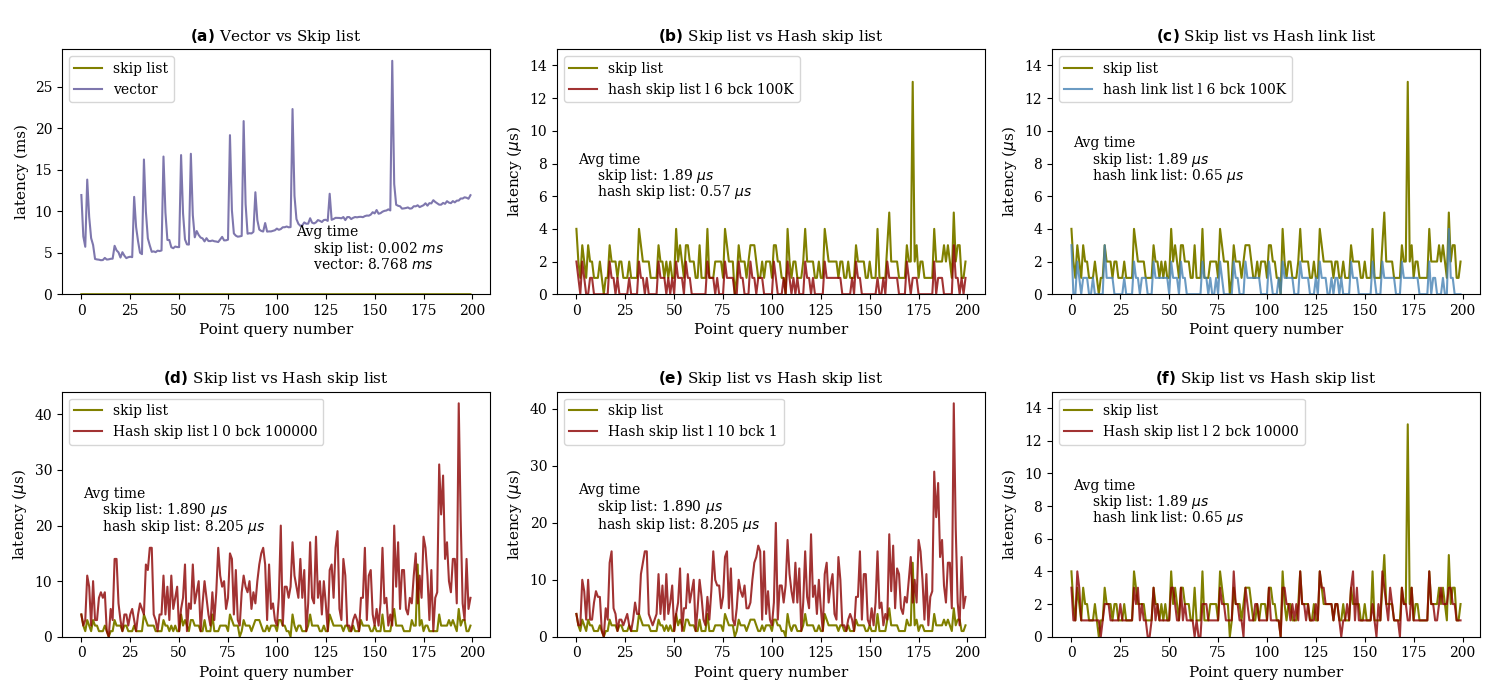

In [28]:
plt.rcParams["font.family"] = "Arial", "Gulasch", "Times", "Times New Roman", "serif"

FIGSIZE = (15, 7)
fig, ax = plt.subplots(2, 3, figsize=FIGSIZE)
ax[0,0].plot(skip_df.index[:200], skip_df['TimeTaken'][:200] / (1000), color='olive', label='skip list')
# ax.plot(vec_sort_time_df.index[:200][:1001], vec_sort_time_df['TimeTaken'][:200][:2001:2].apply(lambda x: x-1000), label='Vector Sort Time')
ax[0,0].plot(vec_df.index[:200], vec_df['TimeTaken'][:200]/(1000), alpha=0.7, color='darkslateblue', label='vector')

ax[0,0].set_title("\n$\mathbf{{(a)}}$ Vector vs Skip list", fontsize=11)
ax[0,0].set_xlabel('Point query number', fontsize=11)
ax[0,0].set_ylabel('latency (ms)', fontsize=11)
ax[0,0].set_ylim(bottom=0)
ax[0,0].legend()
ax[0,0].annotate(f"Avg time", xy=(110,7))
ax[0,0].annotate(f"    skip list: {(skip_df[:200] / 1000).mean()['TimeTaken']:.3f} $\mathit{{ms}}$", xy=(110,5))
ax[0,0].annotate(f"    vector: {(vec_df[:200] / 1000).mean()['TimeTaken']:.3f} $\mathit{{ms}}$", xy=(110,3))



# ax.plot(hash_link_df_0_100000.index[:200], hash_link_df_0_100000['TimeTaken'][:200], alpha=0.4, label='Hash Link List l 0 bck 100000')
# ax.plot(hash_link_df_10_1.index[:200], hash_link_df_10_1['TimeTaken'][:200], alpha=0.4, label='Hash Link List l 10 bck 1')
# ax.plot(hash_skip_df_6_100000.index[:200], hash_skip_df_6_100000['TimeTaken'][:200], alpha=0.4, label='Hash Skip List l 6 bck 100000')
# ax.plot(hash_link_df_6_100000.index[:200], hash_link_df_6_100000['TimeTaken'][:200], alpha=0.4, label='Hash Link List l 6 bck 100000')
# ax.plot(hash_link_df_2_10000.index[:200], hash_link_df_2_10000['TimeTaken'][:200], alpha=0.4, label='Hash Link List l 2 bck 10000')


ax[0,1].plot(skip_df.index[:200], skip_df['TimeTaken'][:200], color='olive', label='skip list')
ax[0,1].plot(hash_skip_df_6_100000.index[:200], hash_skip_df_6_100000['TimeTaken'][:200], alpha=0.8, color='darkred', label='hash skip list l 6 bck 100K')

ax[0,1].set_title("\n$\mathbf{{(b)}}$ Skip list vs Hash skip list", fontsize=11)
ax[0,1].set_xlabel(f'Point query number', fontsize=11)
ax[0,1].set_ylabel('latency ($\mu$s)', fontsize=11)
ax[0,1].set_ylim(bottom=0, top=15)
ax[0,1].legend()
ax[0,1].annotate(f"Avg time", xy=(1,8))
ax[0,1].annotate(f"    skip list: {skip_df[:200].mean()['TimeTaken']:.2f} $\mathit{{\mu}}s$", xy=(2,7))
ax[0,1].annotate(f"    hash skip list: {hash_skip_df_6_100000[:200].mean()['TimeTaken']:.2f} $\mathit{{\mu}}s$", xy=(2,6))





ax[0,2].plot(skip_df.index[:200], skip_df['TimeTaken'][:200], color='olive', label='skip list')
ax[0,2].plot(hash_link_df_6_100000.index[:200], hash_link_df_6_100000['TimeTaken'][:200], alpha=0.8, color='steelblue', label='hash link list l 6 bck 100K')

ax[0,2].set_title("\n$\mathbf{{(c)}}$ Skip list vs Hash link list", fontsize=11)
ax[0,2].set_xlabel('Point query number', fontsize=11)
ax[0,2].set_ylabel('latency ($\mu$s)', fontsize=11)
ax[0,2].set_ylim(bottom=0, top=15)
ax[0,2].legend()
ax[0,2].annotate(f"Avg time", xy=(1,9))
ax[0,2].annotate(f"    skip list: {skip_df[:200].mean()['TimeTaken']:.2f} $\mathit{{\mu}}s$", xy=(2,8))
ax[0,2].annotate(f"    hash link list: {hash_link_df_6_100000[:200].mean()['TimeTaken']:.2f} $\mathit{{\mu}}s$", xy=(2,7))


# ax.set_ylim(bottom= -0.0001, top=0.0013)
# ax[0].set_xlim(left=0, right=1000)

# ax[1].set_xlim(left=0, right=1000)
# ax[1].set_yscale('log')

ax[1,0].plot(skip_df.index[:200], skip_df['TimeTaken'][:200], color='olive', label='skip list')
ax[1,0].plot(hash_skip_df_0_100000.index[:200], hash_skip_df_0_100000['TimeTaken'][:200], alpha=0.8, color='darkred', label='Hash skip list l 0 bck 100000')

ax[1,0].set_title("\n$\mathbf{{(d)}}$ Skip list vs Hash skip list", fontsize=11)
ax[1,0].set_xlabel('Point query number', fontsize=11)
ax[1,0].set_ylabel('latency ($\mu$s)', fontsize=11)
ax[1,0].set_ylim(bottom=0)
ax[1,0].legend()
ax[1,0].annotate(f"Avg time", xy=(1,25))
ax[1,0].annotate(f"    skip list: {(skip_df[:200]).mean()['TimeTaken']:.3f} $\mathit{{\mu}}s$", xy=(2,22))
ax[1,0].annotate(f"    hash skip list: {(hash_skip_df_0_100000[:200]).mean()['TimeTaken']:.3f} $\mathit{{\mu}}s$", xy=(2,19))

ax[1,1].plot(skip_df.index[:200], skip_df['TimeTaken'][:200], color='olive', label='skip list')
ax[1,1].plot(hash_skip_df_10_1.index[:200], hash_skip_df_10_1['TimeTaken'][:200], alpha=0.8, color='darkred', label='Hash skip list l 10 bck 1')

ax[1,1].set_title("\n$\mathbf{{(e)}}$ Skip list vs Hash skip list", fontsize=11)
ax[1,1].set_xlabel(f'Point query number', fontsize=11)
ax[1,1].set_ylabel('latency ($\mu$s)', fontsize=11)
ax[1,1].set_ylim(bottom=0)
ax[1,1].legend()
ax[1,1].annotate(f"Avg time", xy=(1,25))
ax[1,1].annotate(f"    skip list: {(skip_df[:200]).mean()['TimeTaken']:.3f} $\mathit{{\mu}}s$", xy=(2,22))
ax[1,1].annotate(f"    hash skip list: {(hash_skip_df_0_100000[:200]).mean()['TimeTaken']:.3f} $\mathit{{\mu}}s$", xy=(2,19))



ax[1,2].plot(skip_df.index[:200], skip_df['TimeTaken'][:200], color='olive', label='skip list')
ax[1,2].plot(hash_skip_df_2_10000.index[:200], hash_skip_df_2_10000['TimeTaken'][:200], alpha=0.8, color='darkred', label='Hash skip list l 2 bck 10000')

ax[1,2].set_title("\n$\mathbf{{(f)}}$ Skip list vs Hash skip list", fontsize=11)
ax[1,2].set_xlabel('Point query number', fontsize=11)
ax[1,2].set_ylabel('latency ($\mu$s)', fontsize=11)
ax[1,2].set_ylim(bottom=0, top=15)
ax[1,2].legend()
ax[1,2].annotate(f"Avg time", xy=(1,9))
ax[1,2].annotate(f"    skip list: {skip_df[:200].mean()['TimeTaken']:.2f} $\mathit{{\mu}}s$", xy=(2,8))
ax[1,2].annotate(f"    hash link list: {hash_link_df_6_100000[:200].mean()['TimeTaken']:.2f} $\mathit{{\mu}}s$", xy=(2,7))
# ax[1,2].plot(hash_skip_df_10_1.index[:200], hash_skip_df_10_1['TimeTaken'][:200], alpha=0.8, color='darkred', label='Hash Skip List l 10 bck 1')

plt.tight_layout()


In [20]:
workload_txt = "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-PQ-64/workload.txt"

inserts = list()

for line in open(workload_txt, 'r'):
    if line.startswith("I "):
        inserts.append(line.split(' ')[1])

prefix_len = 2

prefix_set = set([ins[:prefix_len] for ins in inserts])

In [21]:
prefix_specific_keys_count = dict()

for k in inserts:
    pref = k[:prefix_len]

    if pref in prefix_specific_keys_count.keys():
        prefix_specific_keys_count[pref] += 1
    else:
        prefix_specific_keys_count[pref] = 1

In [22]:
pqs = list()

i = 0
for line in open(workload_txt, 'r'):
    if line.startswith("Q "):
        pqs.append(i)
        i = 0
    else:
        i += 1

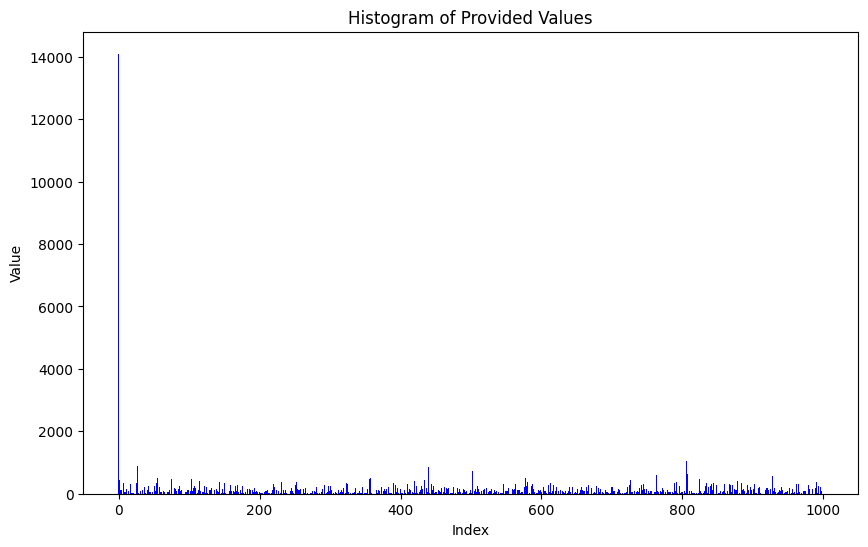

In [23]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(pqs)), pqs, color='blue')
plt.title('Histogram of Provided Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

(array([117.,  92.,  88.,  63.,  57.,  70.,  56.,  43.,  45.,  34.,  42.,
         31.,  30.,  28.,  12.,  22.,  16.,  21.,  16.,  14.,  10.,  18.,
          5.,  14.,   6.,   4.,   2.,   5.,   5.,   1.,   2.,   1.,   4.,
          2.,   0.,   1.,   3.,   0.,   0.,   4.,   3.,   0.,   0.,   1.,
          2.,   1.,   1.,   1.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

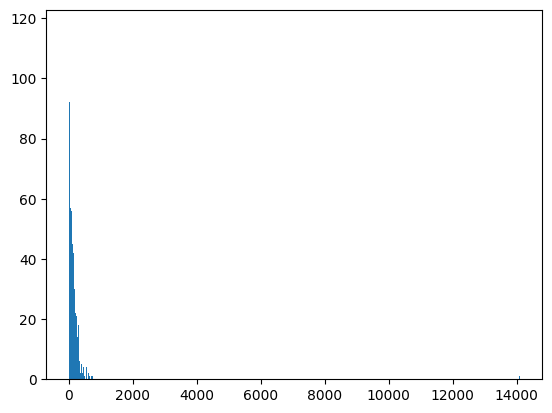

In [24]:
plt.hist(pqs, bins=1000)